# 2025-01-29 Fourier and conditioning

## Last time

* Green's functions, eigenfunctions
* Interpolation of the solution from FD (Vandermonde)
* Differentiation stencil

## Today
* Discuss reading
* Arbitrary order discretization
* Method of manufactured solutions
* Techniques for boundary conditions
* Fourier analysis of stencils


## Reading to discuss today

[Journal of Fluids Engineering: Editorial Policy Statement on the Control of Numerical Accuracy (1986)](https://jedbrown.org/files/RoacheGhiaWhite-JFEEditorialPolicyStatementControlOfNumericalAccuracy-1986.pdf)

* What good practice does this announcement call for?
* Why was it acceptable to omit it in the past?
* What problems could omitting it cause?
* List a few ways one could make sure their numerical experiments are up to stadnard.

## Getting derivatives of the FD solution (more in-depth explanation)

* Let's say we have a target point $\bar{x} \notin \{ x_1, x_2, \ldots, x_n \}$ (not one of the nodes we used in FD)
* We'd like an estimate of $u^{(k)}(\bar{x})$ from the $u(x_i)$

* Taylor series:
$$ u(x_i) = u(\bar{x}) + (x_i - \bar{x})u'(\bar{x}) + \ldots + \frac{1}{k!}(x_i - \bar{x})^k u^{(k)}(\bar{x}) + \ldots \quad \text{for } i = 1, 2, \ldots n.$$

* Linearly combine the $u(x_i)$ to get best estimate for $u^{(k)}(\bar{x})$:
$$  c_1 u(x_1) + c_2 u(x_2) + \ldots + c_n u(x_n) = u^{(k)}(\bar{x}) + \mathcal{O}(h^p) $$
(here, $h$ is some average nodal distance, and $p$ should be as large as possible)

* What are the $c_i$? Use Taylor series to rewrite linear combination:
$$ c_1 \left( u(\bar{x}) + (x_1 - \bar{x})u'(\bar{x}) + \ldots + \frac{1}{k!}(x_1 - \bar{x})^k u^{(k)}(\bar{x})\right) + \ldots + c_n\left(\ldots\right) = u^{(k)}(\bar{x}) + \mathcal{O}(h^p)$$

* Collect coefficients of $u^{(k)}$ to get the constraint
$$ \frac{1}{(i-1)!}\sum_{j = 1}^n c_j (x_j - \bar{x})^{(i-1)} = \begin{cases} 1 \quad \text{if } i-1 = k, \\ 0 \quad \text{otherwise.}\end{cases} $$

* Can express as a Vandermonde system:
$$ \begin{bmatrix} 1 & 1  & \ldots \\ (x_1 - \bar{x}) & (x_2 - \bar{x}) & \ldots \\ \vdots & \vdots & \ddots \\ (x_1 - \bar{k})^{(n-1)} & (x_2 - \bar{k})^{(n-1)} & \ldots\end{bmatrix}\begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \end{bmatrix} = \begin{bmatrix} 0 \\ 1!  \\ \vdots \\ 0\end{bmatrix} $$ 
(place $k!$ in the $(k+1)$th row on the RHS for the $k$th derivative)

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

fdstencil (generic function with 1 method)

## Observations

* Each derivative gives up one order of accuracy in general.
* Centered diff on uniform grids can have extra cancellation (superconvergence)
* The Vandermonde matrix is notoriously ill-conditioned with many points $n$. We recommend using a [stable algorithm from Fornberg](https://doi.org/10.1137/S0036144596322507).
* However, you're only in trouble is condition number $\kappa \approx 1/\varepsilon_M$. See [this recent paper](https://arxiv.org/abs/2212.10519) and [these notes](https://cu-comptools.github.io/fall2024/poly_interp.html#equation-6dc3e0ea-de80-483f-a483-9b6bbaa104e6).

# High order discretization of the Laplacian
The Poisson problem $-u_{xx} = f$ with boundary conditions

In [3]:
function poisson(x, spoints, forcing; left=(0, zero), right=(0, zero)) # Positional; keyword arguments (optional)
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x) # forcing is an input function
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2) # Second derivative via the stencil we derived
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1]) 
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1]) # Exercise: what do these two lines mean? 
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson (generic function with 1 method)

In [4]:
L, b = poisson(LinRange(-1, 1, 6), 3, zero, left=(1, zero)) # Nodes are 6 equispaced points on [-1, 1]
L

6×6 Matrix{Float64}:
 -3.75   5.0   -1.25   0.0    0.0    0.0
 -6.25  12.5   -6.25   0.0    0.0    0.0
  0.0   -6.25  12.5   -6.25   0.0    0.0
  0.0    0.0   -6.25  12.5   -6.25   0.0
  0.0    0.0    0.0   -6.25  12.5   -6.25
  0.0    0.0    0.0    0.0   -0.0    1.0

* **Question:** how do we test the convergence of this PDE solver (and the correctness of the code)?
    * Your ideas...
   

 
    
* Good practice:
    * Think of what a function will do (inputs, outputs, its objective)
    * Write its docstring / documentation
    * Think of a test for its functionality
    * Write a _unit test_ 
    * Then, and only then, write the function.

# Method of manufactured solutions

= A way to validate that a PDE system is being solved correctly.

## Problem: analytic solutions to PDEs are hard to find

Let's choose a smooth function with rich derivatives,
$$ u(x) = \tanh(x) . $$
Then $$ u'(x) = \cosh^{-2}(x) $$ and $$ u''(x) = -2 \tanh(x) \cosh^{-2}(x) . $$

* This works for nonlinear too.

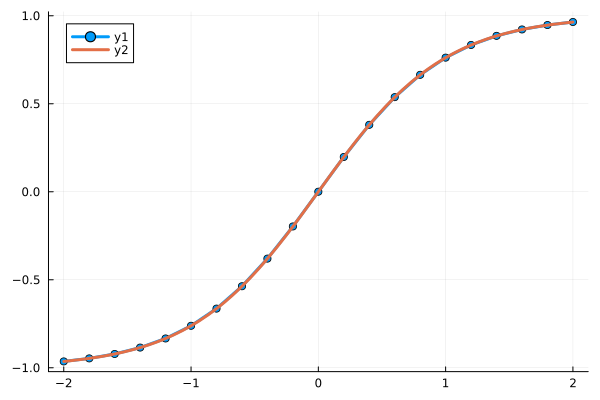

In [5]:
x = LinRange(-2, 2, 21)
L, rhs = poisson(x, 5,
    x -> 2 * tanh(x) / cosh(x)^2,
    left=(0, tanh), 
    right=(1, x -> cosh(x)^-2))
u = L \ rhs
plot(x, u, marker=:circle, legend=:topleft)
plot!(tanh)

# Convergence rate

In [6]:
ns = 2 .^ (4:10)
hs = 1 ./ ns
function poisson_error(n; spoints=3)
    x = LinRange(-2, 2, n)
    L, rhs = poisson(x, spoints, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end

poisson_error (generic function with 1 method)

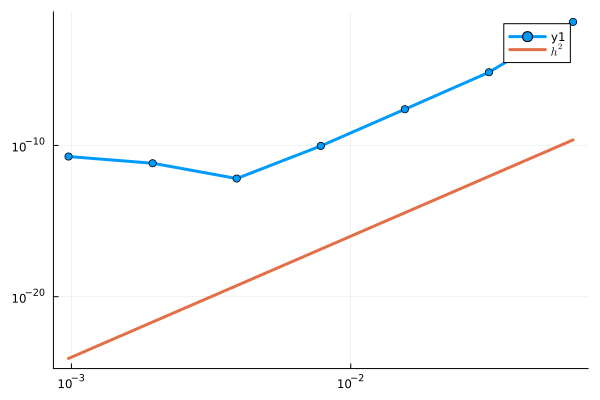

In [7]:
plot(hs, [poisson_error(n, spoints=9) for n in ns], marker=:circle)
plot!(h -> h^8, label="\$h^2\$", xscale=:log10, yscale=:log10)

# Question: what's going wrong at small h?

# Symmetry in boundary conditions: Dirichlet

We have implemented Dirichlet conditions by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{1:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{1:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{1:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.
* We can eliminate $u_0$ and create a reduced system for $u_{1:}$.
* Generalize: consider a $2\times 2$ block system
$$ \begin{bmatrix} I & 0 \\ A_{10} & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 \end{bmatrix} .$$

We can rearrange as
$$ A_{11} u_1 = f_1 - A_{10} f_0, $$
which is symmetric if $A_{11}$ is.
* This is called "lifting" and is often done implicitly in the mathematics literature.  It is convenient for linear solvers and eigenvalue solvers, but inconvenient for IO and postprocessing, as well as some nonlinear problems.
* Convenient alternative: write
$$ \begin{bmatrix} I & 0 \\ 0 & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 - A_{10} f_0 \end{bmatrix}, $$
which is symmetric and decouples the degrees of freedom associated with the boundary. This method applies cleanly to nonlinear problems.
* Optionally scale the identity by some scalar related to the norm of $A_{11}$.

# Symmetry in boundary conditions: Neumann

Consider FD discretization of the Neumann boundary condition
$$ \frac{du}{dx}(1) = b . $$
1. Use a one-sided difference formula as in
$$ \frac{u_n - u_{n-1}}{h} = b . $$
  * an extra discretization choice
  * may reduce order of accuracy compared to interior discretization, lose symmetry.
2. Temporarily introduce a ghost value $u_{n+1} = u(x_{n+1} = 1 + h)$ (possibly more) and define it to be a reflection of the values from inside the domain.  In the case $b=0$, this reflection is $u_{n+i} = u_{n-i}$.  More generally,
$$ u_{n+i} = u_{n-i} + 2b(x_n - x_{n-i}) . $$

After this definition of ghost values, we apply the interior discretization at the boundary. For our reference equation, we would write

$$ \frac{-u_{n-1} + 2 u_n - u_{n+1}}{h^2} = f(x_n) $$

which simplifies to $$ \frac{u_n - u_{n-1}}{h^2} = f(x_n)/2 + b/h $$
after dividing by 2 and moving the boundary term to the right hand side.

# Fourier analysis of stencils

Consider the plane waves $\phi(x, \theta) = e^{i\theta x}$.

Sample $\phi$ on a discrete grid $x = \mathbb Z$ and apply the stencil
\begin{align}
S \phi(x, \theta) &= s_{-1} \phi(x-1, \theta) + s_{0} \phi(x, \theta) + s_1 \phi(x+1,\theta) \\
&= \Big( s_{-1} e^{-i\theta} + s_0 + s_{1} e^{i\theta} \Big) \phi(x, \theta)
\end{align}
With $S = \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$, we get
$$S \phi(x, \theta) = \underbrace{(2 - 2 \cos\theta)}_{\hat S(\theta)} \phi(x, \theta)$$
We call $\hat S(\theta)$ the *symbol* of the operator.
**Exercise**: What is the symbol of the continuous second derivative?

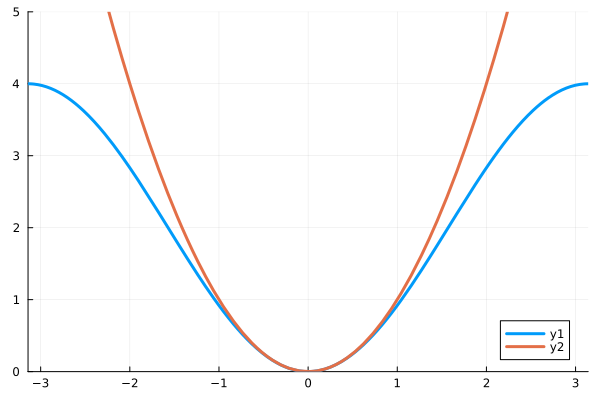

In [8]:
plot([theta -> 2 - 2*cos(theta),
        theta -> theta^2],
    xlims=(-pi, pi), ylim=(0, 5))

# Numerically computing symbols

In [9]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

theta = LinRange(-pi, pi, 10)
symbol([-1 1 0], theta)
symbol([1 -2 1], theta)

10-element Vector{ComplexF64}:
                 -4.0 + 0.0im
   -3.532088886237956 + 0.0im
    -2.34729635533386 + 0.0im
  -1.0000000000000004 + 0.0im
 -0.12061475842818326 + 0.0im
 -0.12061475842818326 + 0.0im
  -0.9999999999999992 + 0.0im
    -2.34729635533386 + 0.0im
   -3.532088886237956 + 0.0im
                 -4.0 + 0.0im

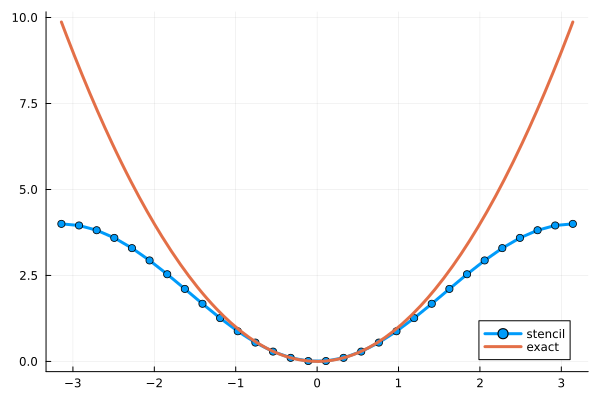

In [10]:
function plot_symbol(S, deriv, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    plot!(fig, th -> th^deriv, label="exact")
    fig
end

plot_symbol([-1 1 0], 1)
plot_symbol([1 -2 1], 2)

# Stencils of high-order operators

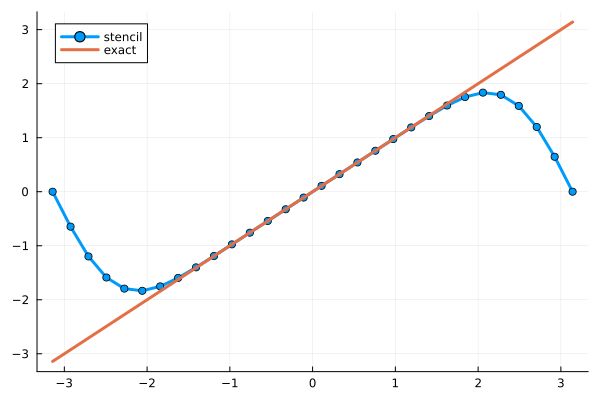

In [11]:
x = -5:5
plot_symbol(fdstencil(x, 0, 1), 1)

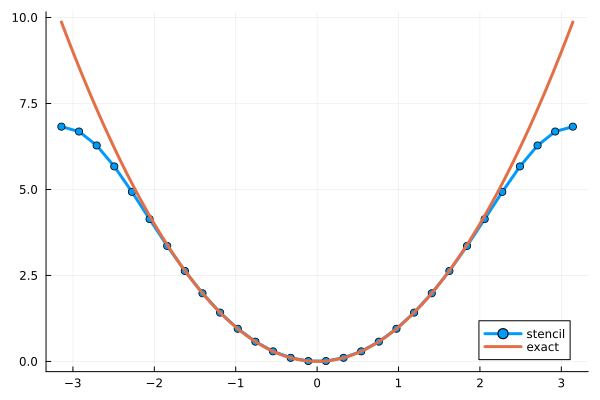

In [12]:
x = -5:5
plot_symbol(fdstencil(x, 0, 2), 2)

# Outlook on Fourier methods

* the Fourier modes $e^{i\theta x}$ and their multi-dimensional extensions are eigenvectors of **all** stencil-type operations
* "high frequencies" $[-\pi, \pi) \setminus [-\pi/2, \pi/2)$ are generally poorly resolved so we need to use a grid fine enough that important features are at low frequencies $[-\pi/2, \pi/2)$
* same technique can be used to study the inverse (and approximations thereof), as with multigrid and multilevel domain decomposition methods (later in the course)
* these methods can also be framed within the theory of (block) Toeplitz matrices